In [1]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

try:
    from plotting import plot_autoencoder_stats
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

/Users/billhikari/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/billhikari/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/billhikari/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <552B36CA-07A6-332B-BF7F-6D22D9005F71> /Users/billhikari/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Unsupservised Learning 

## Labelling Data is Expensive

In supervised machine learning, one aims at learning a mapping $f_{\psi} : \mathbf{x} \in \mathcal{R}^P \rightarrow \mathbf{y}$ from observations $\mathbf{x}$ to the target $\mathbf{y}$ using a dataset $\mathcal{D} = \{\mathbf{x}_i, \mathbf{y}_i\}_{i=1, \dots, N}$ of finite size N (e.g. image classification, translation). Because of the curse of dimensionality, high-dimensional inputs (images) and complex the models (deep learning) require large datasets (million of pairs $(\mathbf{x}, \mathbf{y})$). In practice, labelling data is expensive (e.g. marking the presence of cancer in X-ray chest scans). 

## Compression is Comprehension: Learning without Target

In order to overcome the curse of dimensionality, we aim at learning a compressed representation $\mathbf{z} \in \mathcal{R}^M$ of $\mathbf{x}$ such that $M < P$ and there is a mapping $g_{\phi}: \mathbf{x} \rightarrow \mathbf{z}$ linking each data point to its representation. Ideally, $\mathbf{z}$ is low-dimensional set of features which efficiently describes $\mathbf{x}$. As an illustration, when modelling pictures of celebrities (CelebA dataset), the set of facial features (eye color, age, hair lenth, etc.) is a compressed (and lossy) representation of $\mathbf{x}$. In practice, the representation  $\mathbf{z}$ is unobservable and [unlikely to overlap with such known features](https://arxiv.org/abs/1811.12359). Yet, the representation $\mathbf{z}$ is low dimensional and learning a mapping $f_{\psi} : \mathbf{z} \in \mathcal{R}^M \rightarrow \mathbf{y}$ is often easier.

Whereas labelling the data is expensive, observations $\mathbf{x}$ are cheap to acquire. In many cases, one can scrap the web to gather a large collection of images or text. As a result, large deep learning models can be deployed to learn $g_{\phi}$, and smaller / data-efficient models can be applied downstream to solve the supervised task.



# Auto-encoders: Compression as a Generation Process
In this notebook you will implement a simple auto-encoder (AE). We assume that you are already familiar with the basics of neural networks. We will start by defining an AE similar to the one used for the finetuning step by [Geoffrey Hinton and Ruslan Salakhutdinov](https://www.cs.toronto.edu/~hinton/science.pdf). We will experiment with the AE setup and try to run it on the MNIST dataset. There has been a wide variety of research into the field of auto-encoders and the technique that you are about to learn is very simple compared to modern methods: Masked Autoencoders ([MADE](https://arxiv.org/abs/1502.03509), [BERT](https://arxiv.org/abs/1810.04805)) and Variational Autoencoders ([VAE](https://arxiv.org/abs/1312.6114), [VQ-VAE](https://arxiv.org/abs/1711.00937), [BIVA](https://arxiv.org/abs/1902.02102), [NVAE](https://arxiv.org/abs/2007.03898)).

In unsupervised learning, we aim at learning compressed representations $\mathbf{z} \in \mathcal{P}$ of $\mathbf{x} \in \mathcal{R}$ where $ M < P$. The architecture of an autoencoder can be decomposed in two steps:

1. *Encoding* $\mathbf{x}$ into a low-dimensional representation $\mathbf{z}$ using a neural network $g_{\phi} : \mathbf{x} \rightarrow \mathbf{z}$.
2. *Decoding* the representation $\mathbf{z}$ into a reconstruction $\hat{\mathbf{x}} = h_\theta(\mathbf{z}) \in \mathcal{R}^P$.

Because $M < P$, the encoding acts as an information bottleneck: only part of the information describing $\mathbf{x}$ can be encoded into $\mathbf{z}$ as long as $M$ is sufficiently small.

Learning the parameters of the autoencoder relies on two aspects:

1. A distance in the observation space $d : \mathcal{R}^{P} \times \mathcal{R}^{P} \rightarrow \mathcal{R}$ (e.g. MSE), measuring the reconstruction quality.
2. Using backpropagation coupled with stochastic gradient descent (SGD) to optimize the parameters $\{\phi, \theta\}$ w.r.t $L := \frac{1}{N} \sum_i d(x_i, h_{\theta}(g_{\phi}(\mathbf{x})))$.

<img src="static/autoencoder.png" />

*The exercises are found at the bottom of the notebook*

## MNIST
First let us load the MNIST dataset and plot a few examples. In this notebook we will use the *dataloaders* and *datasets* provided by PyTorch. Defining the loading of datasets using a dataloader has the advantage that it only load the data that is *neccessary* into memory, which enables us to use very large scale datasets.

We only load a limited amount of classes defined by the `classes` variable to speed up training.

In [2]:
import torch
cuda = torch.cuda.is_available()

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Flatten the 2d-array image into a vector
flatten = lambda x: ToTensor()(x).view(28**2)

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

# The digit classes to use
classes = [3, 7]

def stratified_sampler(labels, classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    from functools import reduce
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


# The loaders perform the actual work
batch_size = 64
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets, classes), pin_memory=cuda)
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets, classes), pin_memory=cuda)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1002)>



100%|██████████| 9912422/9912422 [00:04<00:00, 2408058.55it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1002)>



100%|██████████| 28881/28881 [00:00<00:00, 1138397.07it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1002)>



100%|██████████| 1648877/1648877 [00:00<00:00, 2961281.11it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1002)>



100%|██████████| 4542/4542 [00:00<00:00, 1585958.11it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



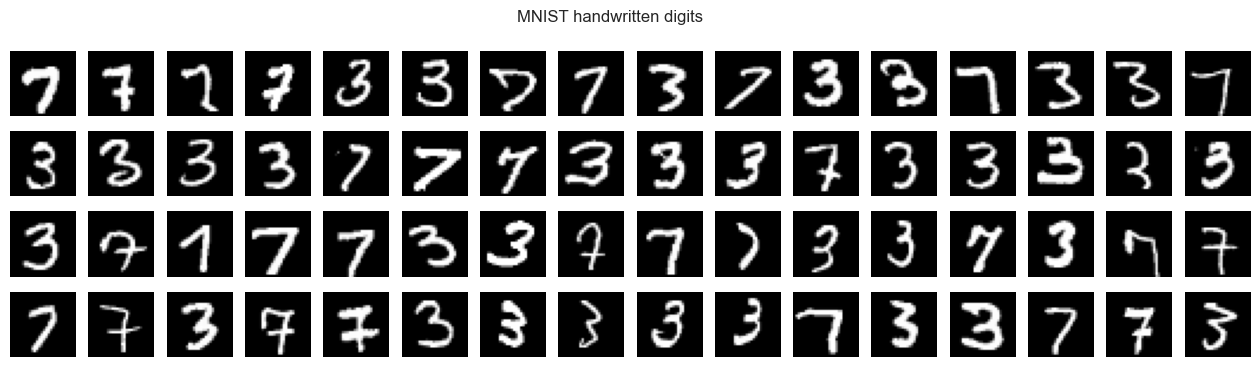

In [3]:
# Plot a batch of MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

### Building the model
When defining the model the latent layer $z$ must act as a bottleneck of information. We initialize the AE with 1 hidden layer in the encoder and decoder using ReLU units as nonlinearities. The latent layer has a dimensionality of 2 in order to make it easy to visualise. Since $x$ are pixel intensities that are normalized between 0 and 1, we use the sigmoid nonlinearity to model the reconstruction.

In [4]:
import torch.nn as nn

# define size variables
num_features = 28*28

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units, latent_features=2):
        super(AutoEncoder, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=hidden_units, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        # apply sigmoid to output to get pixel intensities between 0 and 1
        x_hat = torch.sigmoid(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }


# Choose the shape of the autoencoder
net = AutoEncoder(hidden_units=128, latent_features=2)

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
  )
)


Following we define the PyTorch functions for training and evaluation.

In [9]:
import torch.optim as optim

# if you want L2 regularization, then add weight_decay to SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()

We can test the forward pass by checking whether the output shape is the same as the as the input.

In [10]:
# test the forward pass
# expect output size of [32, num_features]
x, y = next(iter(train_loader))
print(f"x.shape = {x.shape}")

if cuda:
    x = x.cuda()

outputs = net(x)
print(f"x_hat.shape = {outputs['x_hat'].shape}")


x.shape = torch.Size([64, 784])
x_hat.shape = torch.Size([64, 784])


In the training loop we sample each batch and evaluate the error, latent space, and reconstructions on every epoch.

**NOTE** this will take a while on CPU.

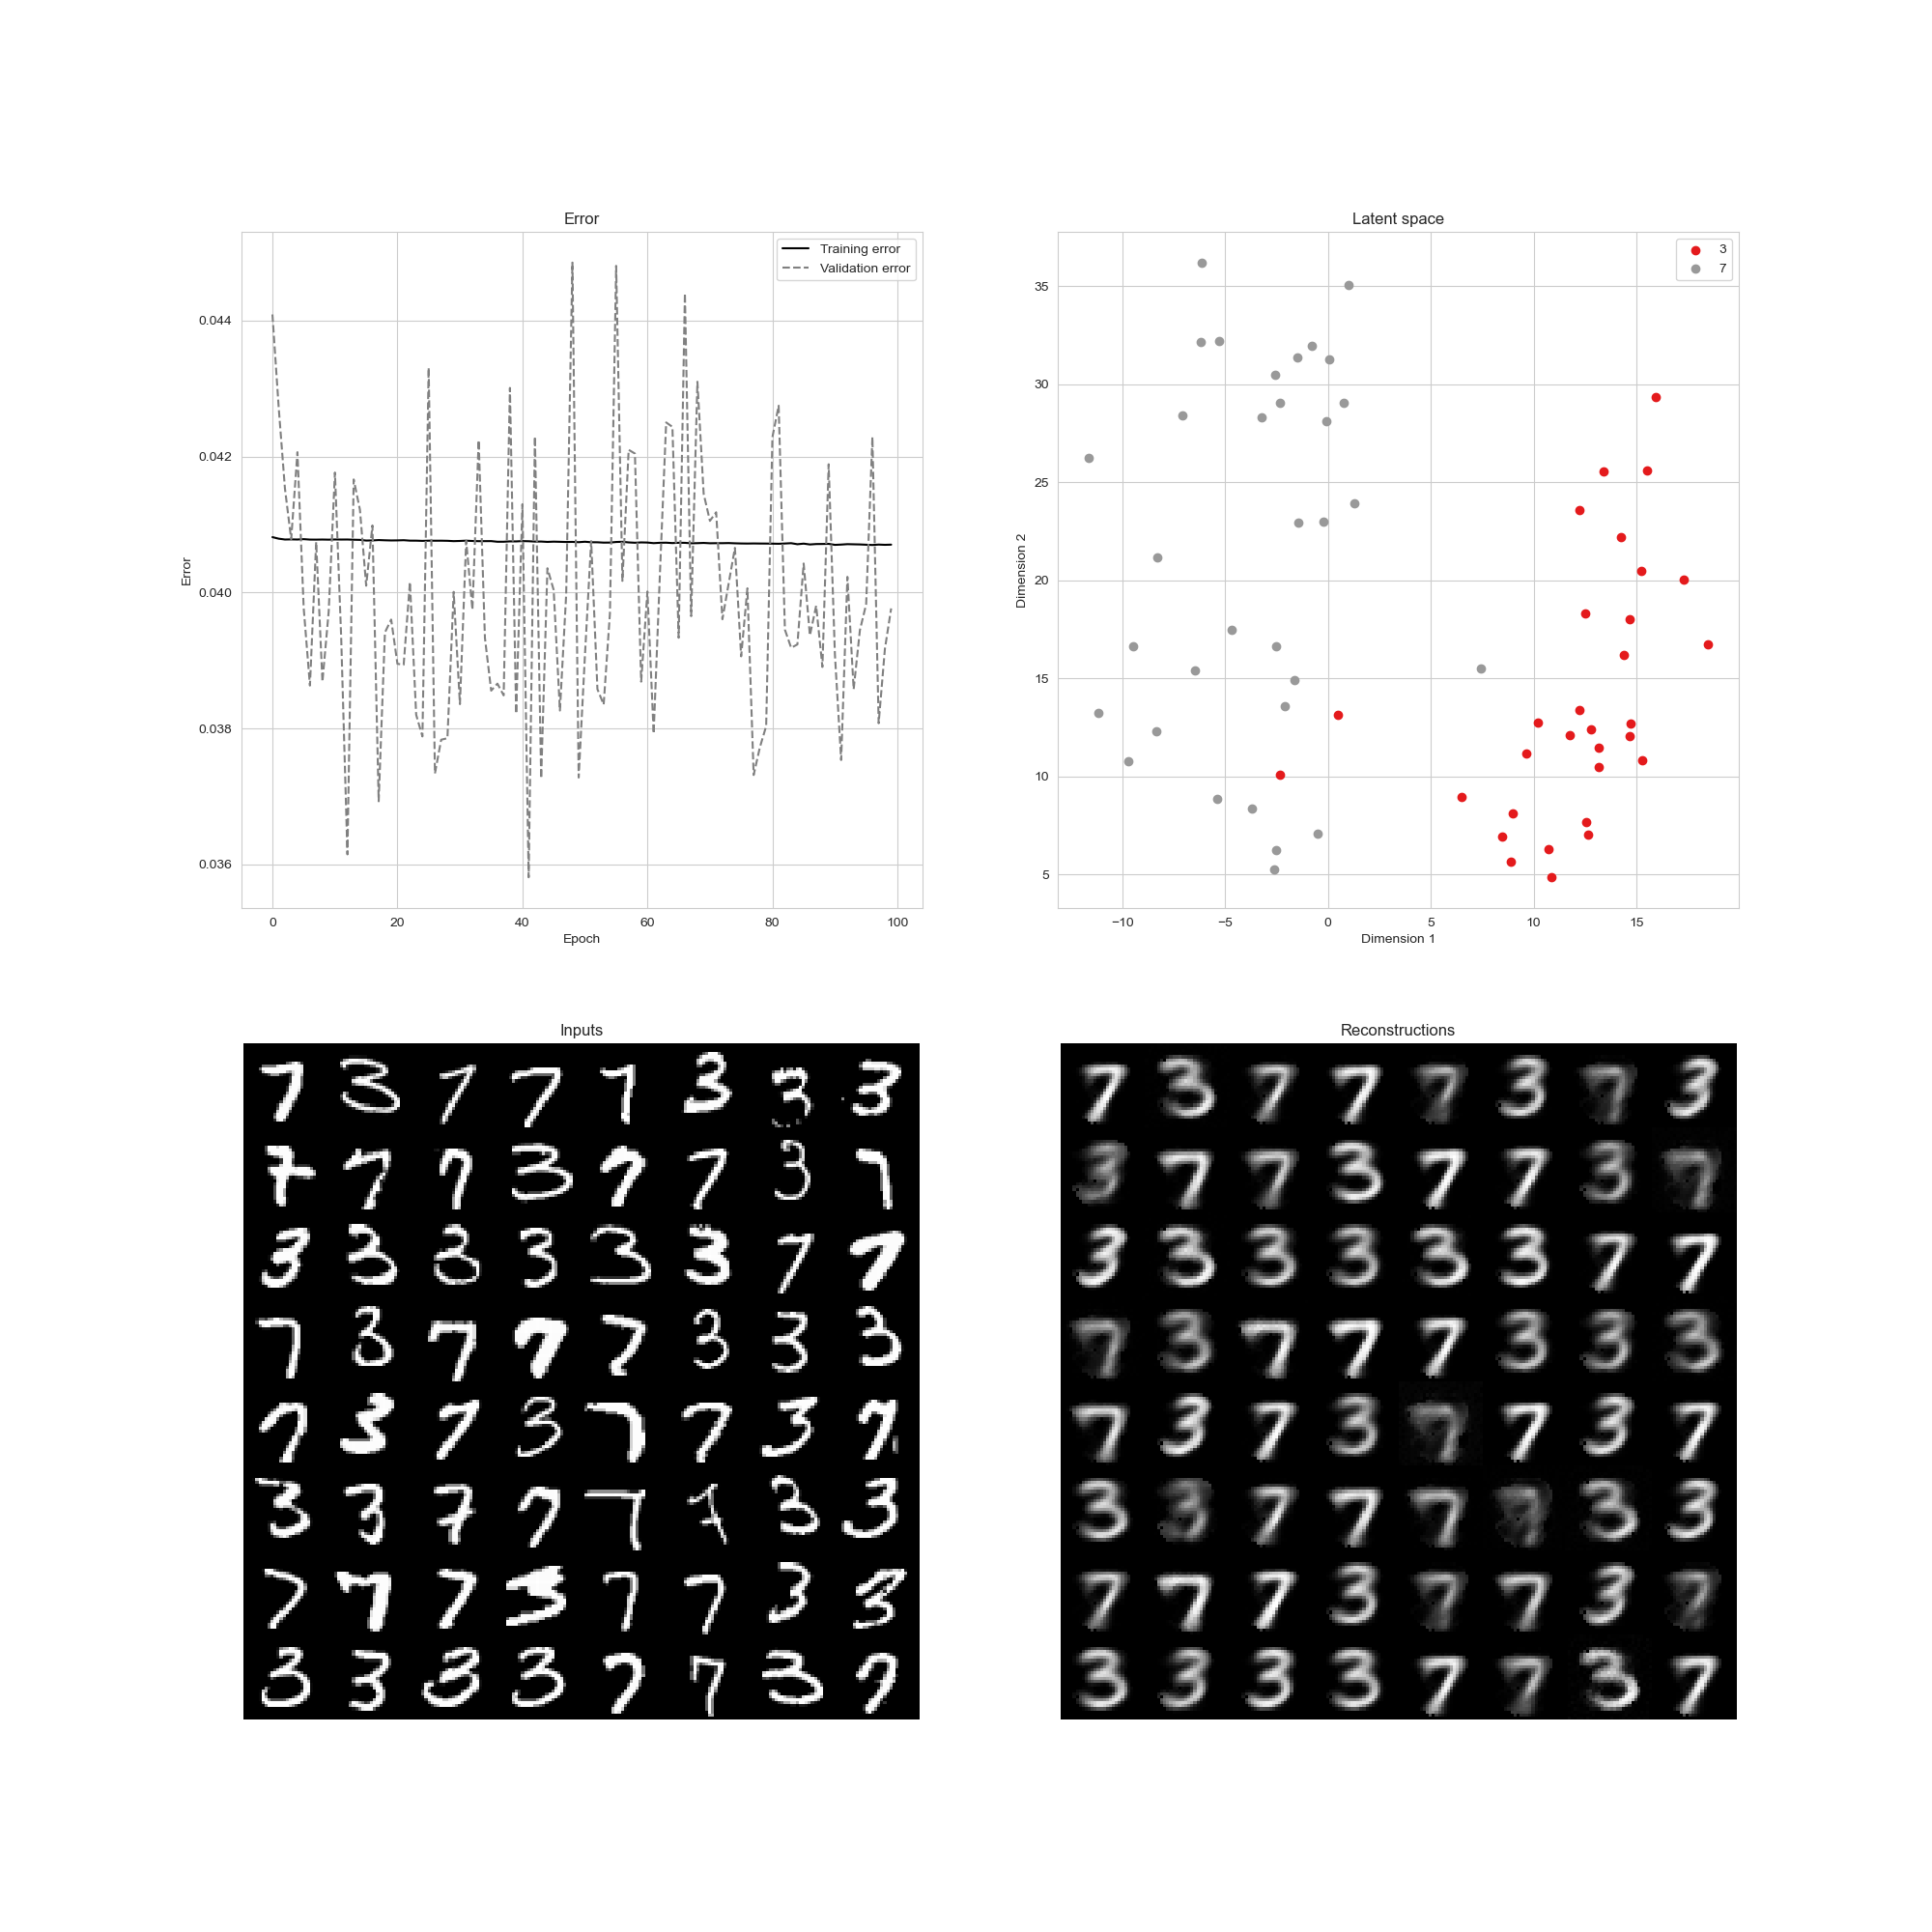

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_epochs = 100

train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        
        if cuda:
            x = x.cuda()
        
        outputs = net(x)
        x_hat = outputs['x_hat']

        # note, target is the original tensor, as we're working with auto-encoders
        loss = loss_function(x_hat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())

    train_loss.append(np.mean(batch_loss))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        
        if cuda:
            x = x.cuda()
        
        outputs = net(x)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x_hat = outputs['x_hat']
        z = outputs['z'].cpu().numpy()

        loss = loss_function(x_hat, x)

        valid_loss.append(loss.item())
    
    if epoch == 0:
        continue

    # live plotting of the trainig curves and representation
    plot_autoencoder_stats(x=x.cpu(),
                           x_hat=x_hat.cpu(),
                           z=z,
                           y=y,
                           train_loss=train_loss,
                           valid_loss=valid_loss,
                           epoch=epoch,
                           classes=classes,
                           dimensionality_reduction_op=None)
    
   

# Assignments

## Assignment 1 - Analyzing the AE
1. The above implementation of an AE is very simple.
    - Experiment with the number of layers and try different non-linearities in order to improve the reconstructions
    - What happens with the network when we change the non-linearities in the latent layer (e.g. sigmoid)?
    - Try to increase the number of digit classes in the training set and analyze the results
    - Test different optimization algorithms such as ADAM and RMSProp and decide whether you should use regularizers
       
2. Currently we optimize w.r.t. mean squared error. 
    - Find another error function that could fit this problem better
    - Evaluate whether the similarity function $d$ is a better choice and explain your findings

3. Complexity of the bottleneck.
    - Increase the number of units in the latent layer and train
    - Visualize by using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [35]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),   # Assume input is flattened 28x28 MNIST image
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),    # Latent space with 64 dimensions
            nn.ReLU()  # Modify with Sigmoid/Tanh to test different activations
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()  # Sigmoid to ensure output is in the [0, 1] range for images
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed

# Instantiate and test the modified AE
autoencoder = Autoencoder()

# Loss function: MSE (Mean Squared Error)
criterion = nn.MSELoss()

# Optimizer: ADAM, we will experiment with RMSProp later
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [36]:
# Training the AE on the MNIST dataset
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0
    for (x, _) in unlabelled:  # Use unlabelled data for unsupervised learning
        x = x.view(x.size(0), -1)  # Flatten the images
        optimizer.zero_grad()
        reconstructed = autoencoder(x)
        loss = criterion(reconstructed, x)  # MSE loss between input and reconstruction
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss}')

Epoch 1, Loss: 11.173593498766422
Epoch 2, Loss: 5.5734753999859095
Epoch 3, Loss: 4.411645635962486
Epoch 4, Loss: 3.832857199013233
Epoch 5, Loss: 3.3745285030454397
Epoch 6, Loss: 2.9893161300569773
Epoch 7, Loss: 2.6887975865975022
Epoch 8, Loss: 2.4478096570819616
Epoch 9, Loss: 2.2306688725948334
Epoch 10, Loss: 2.058221689425409
Epoch 11, Loss: 1.9298000112175941
Epoch 12, Loss: 1.8110904819332063
Epoch 13, Loss: 1.724119171500206
Epoch 14, Loss: 1.635593546088785
Epoch 15, Loss: 1.5653087380342185
Epoch 16, Loss: 1.50203935848549
Epoch 17, Loss: 1.447288568597287
Epoch 18, Loss: 1.3951312955468893
Epoch 19, Loss: 1.3548203581012785
Epoch 20, Loss: 1.3108548941090703


In [37]:
# Example of changing the latent layer activation
class AutoencoderWithSigmoid(nn.Module):
    def __init__(self):
        super(AutoencoderWithSigmoid, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Sigmoid()  # Using Sigmoid in the latent layer
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed

# Train this model similarly as above to compare the results.

In [38]:
# Training the AE on the MNIST dataset
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0
    for (x, _) in unlabelled:  # Use unlabelled data for unsupervised learning
        x = x.view(x.size(0), -1)  # Flatten the images
        optimizer.zero_grad()
        reconstructed = autoencoder(x)
        loss = criterion(reconstructed, x)  # MSE loss between input and reconstruction
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss}')

Epoch 1, Loss: 1.2751277931965888
Epoch 2, Loss: 1.2407590174116194
Epoch 3, Loss: 1.20671482430771
Epoch 4, Loss: 1.1797879221849144
Epoch 5, Loss: 1.1491924077272415
Epoch 6, Loss: 1.1209631147794425
Epoch 7, Loss: 1.0954331723041832
Epoch 8, Loss: 1.0797710232436657
Epoch 9, Loss: 1.0569591904059052
Epoch 10, Loss: 1.0318047069013119
Epoch 11, Loss: 1.0228572827763855
Epoch 12, Loss: 0.9962249994277954
Epoch 13, Loss: 0.9740206180140376
Epoch 14, Loss: 0.9568177051842213
Epoch 15, Loss: 0.9441023203544319
Epoch 16, Loss: 0.9287172090262175
Epoch 17, Loss: 0.9138995013199747
Epoch 18, Loss: 0.9014574091415852
Epoch 19, Loss: 0.8964550704695284
Epoch 20, Loss: 0.8780862658750266


In [39]:
# Using RMSProp instead of Adam
optimizer = torch.optim.RMSprop(autoencoder.parameters(), lr=1e-3)

# Train the autoencoder with this new optimizer (same training loop as above).

In [40]:
# Training the AE on the MNIST dataset
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0
    for (x, _) in unlabelled:  # Use unlabelled data for unsupervised learning
        x = x.view(x.size(0), -1)  # Flatten the images
        optimizer.zero_grad()
        reconstructed = autoencoder(x)
        loss = criterion(reconstructed, x)  # MSE loss between input and reconstruction
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss}')


Epoch 1, Loss: 3.543537189718336
Epoch 2, Loss: 1.7651804448105395
Epoch 3, Loss: 1.657514146529138
Epoch 4, Loss: 1.5739069320261478
Epoch 5, Loss: 1.5410953448154032
Epoch 6, Loss: 1.5010632718913257
Epoch 7, Loss: 1.4581801504828036
Epoch 8, Loss: 1.421352210920304
Epoch 9, Loss: 1.4143592370674014
Epoch 10, Loss: 1.3918949062936008
Epoch 11, Loss: 1.3535153027623892
Epoch 12, Loss: 1.3452095440588892
Epoch 13, Loss: 1.3024169150739908
Epoch 14, Loss: 1.2969594784080982
Epoch 15, Loss: 1.2866194127127528
Epoch 16, Loss: 1.2472273730672896
Epoch 17, Loss: 1.240541972219944
Epoch 18, Loss: 1.214566522743553
Epoch 19, Loss: 1.2166227111592889
Epoch 20, Loss: 1.2018172438256443


In [41]:
# Binary Cross-Entropy loss for reconstruction (useful if pixel values are in [0, 1])
criterion = nn.BCELoss()

# Train the AE using this criterion (same training loop as above).


In [42]:
# Training the AE on the MNIST dataset
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0
    for (x, _) in unlabelled:  # Use unlabelled data for unsupervised learning
        x = x.view(x.size(0), -1)  # Flatten the images
        optimizer.zero_grad()
        reconstructed = autoencoder(x)
        loss = criterion(reconstructed, x)  # MSE loss between input and reconstruction
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss}')


Epoch 1, Loss: 16.492313496768475
Epoch 2, Loss: 15.461128570139408
Epoch 3, Loss: 15.419097781181335
Epoch 4, Loss: 15.362433828413486
Epoch 5, Loss: 15.284749299287796
Epoch 6, Loss: 15.25199779868126
Epoch 7, Loss: 15.180106595158577
Epoch 8, Loss: 15.110841572284698
Epoch 9, Loss: 15.119729489088058
Epoch 10, Loss: 15.074448697268963
Epoch 11, Loss: 15.04770352691412
Epoch 12, Loss: 14.993078425526619
Epoch 13, Loss: 14.9591229185462
Epoch 14, Loss: 14.938316024839878
Epoch 15, Loss: 14.913970865309238
Epoch 16, Loss: 14.864701926708221
Epoch 17, Loss: 14.852642476558685
Epoch 18, Loss: 14.829199478030205
Epoch 19, Loss: 14.79378942400217
Epoch 20, Loss: 14.749781630933285


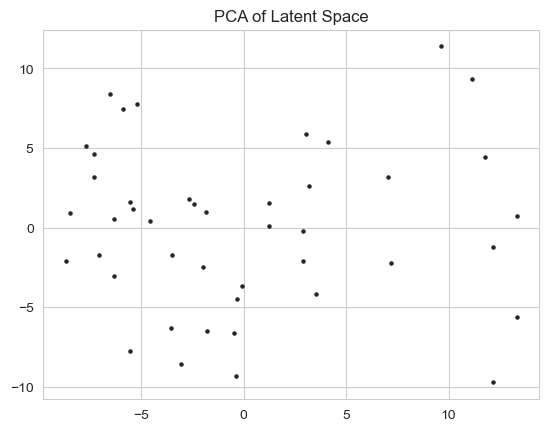

In [44]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have latent outputs (z) for some data samples:
z = autoencoder.encoder(x).detach().cpu().numpy()

# Visualizing with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(z)
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=5)
plt.title('PCA of Latent Space')
plt.show()



## Assignment 2 - Adding classification for semi-supervised learning

The above training has been performed unsupervised. Now let us assume that we only have a fraction of labeled data points from each class. As we know, semi-supervised learning can be utilized by combining unsupervised and supervised learning. Now you must analyze whether a trained AE from the above exercise can aid a classifier.

1. Build a simple classifier (like the ones from week1) where you:
    - Train on the labeled dataset and evaluate the results
2. Build a second classifier and train on the latent output $\mathbf{z}$ of the AE.
3. Build a third classifier and train on the reconstructions of the AE.
4. Evaluate the classifiers against each other and implement a model that improves the classification by combining the input, latent output, and reconstruction.

Below we provide some starting code for using only a subset of the labelled data.

In [12]:
def uniform_stratified_sampler(labels, classes, n=None):
    """
    Stratified sampler that distributes labels uniformly by
    sampling at most n data points per class
    """
    from functools import reduce
    # Only choose digits in n_labels
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))

    # Ensure uniform distribution of labels
    np.random.shuffle(indices)
    indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in classes])

    indices = torch.from_numpy(indices)
    sampler = SubsetRandomSampler(indices)
    return sampler


batch_size = 64

# Specify how many labelled examples we want per digit class
labels_per_class = 10

# Large pool of unlabelled data
unlabelled = DataLoader(dset_train, batch_size=batch_size, 
                        sampler=stratified_sampler(dset_train.train_labels, classes=classes), pin_memory=cuda)

# Smaller pool of labelled data
labelled = DataLoader(dset_train, batch_size=batch_size,
                      sampler=uniform_stratified_sampler(dset_train.train_labels, classes=classes, n=labels_per_class),
                      pin_memory=cuda)

/Users/billhikari/anaconda3/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [47]:
from itertools import cycle

# This is an example of how you can use both the labelled
# and unlabelled loader in unison

### Define your classifier ###
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)
input_dim = 28 * 28
num_classes = 10
simple_classifier = SimpleClassifier(input_dim, num_classes)

# Define optimizer and loss function
optimizer = optim.Adam(simple_classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    simple_classifier.train()
    total_loss = 0
    for (x, y) in labelled:  # Use the labeled data for training
        x, y = x, y
        optimizer.zero_grad()
        outputs = simple_classifier(x.view(x.size(0), -1))  # Flatten the images
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss}')

Epoch 1, Loss: 2.380028247833252
Epoch 2, Loss: 2.219329357147217
Epoch 3, Loss: 2.064880847930908
Epoch 4, Loss: 1.9174859523773193
Epoch 5, Loss: 1.7778793573379517
Epoch 6, Loss: 1.6466652154922485
Epoch 7, Loss: 1.5242741107940674
Epoch 8, Loss: 1.410934567451477
Epoch 9, Loss: 1.3066602945327759
Epoch 10, Loss: 1.2112538814544678


In [48]:
# Classifier for latent representations from AE
class LatentClassifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(LatentClassifier, self).__init__()
        self.fc = nn.Linear(latent_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

# Assume 'autoencoder' is a trained autoencoder model
latent_dim = 64  # Latent dimension in the autoencoder
latent_classifier = LatentClassifier(latent_dim, num_classes)

# Optimizer and loss function
optimizer = optim.Adam(latent_classifier.parameters(), lr=1e-3)

# Training loop on the latent space
for epoch in range(num_epochs):
    latent_classifier.train()
    total_loss = 0
    for (x, y) in labelled:
        x, y = x, y
        latent_output = autoencoder.encoder(x)  # Get latent features from AE
        outputs = latent_classifier(latent_output)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss}')


Epoch 1, Loss: 4.286290168762207
Epoch 2, Loss: 4.110045433044434
Epoch 3, Loss: 3.9360249042510986
Epoch 4, Loss: 3.7646307945251465
Epoch 5, Loss: 3.5963134765625
Epoch 6, Loss: 3.431568145751953
Epoch 7, Loss: 3.2709312438964844
Epoch 8, Loss: 3.1149680614471436
Epoch 9, Loss: 2.9642577171325684
Epoch 10, Loss: 2.8193728923797607


In [49]:
# Classifier for AE reconstructions
reconstruction_classifier = SimpleClassifier(input_dim, num_classes)

# Optimizer
optimizer = optim.Adam(reconstruction_classifier.parameters(), lr=1e-3)

# Training loop on the AE reconstructions
for epoch in range(num_epochs):
    reconstruction_classifier.train()
    total_loss = 0
    for (x, y) in labelled:
        x, y = x, y
        reconstructed_x = autoencoder(x)  # Get reconstructed image from AE
        outputs = reconstruction_classifier(reconstructed_x.view(reconstructed_x.size(0), -1))
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss}')


Epoch 1, Loss: 2.2443578243255615
Epoch 2, Loss: 2.084044933319092
Epoch 3, Loss: 1.9314420223236084
Epoch 4, Loss: 1.7875171899795532
Epoch 5, Loss: 1.6530841588974
Epoch 6, Loss: 1.528707504272461
Epoch 7, Loss: 1.4146167039871216
Epoch 8, Loss: 1.310685396194458
Epoch 9, Loss: 1.2164710760116577
Epoch 10, Loss: 1.1312971115112305


In [50]:
class CombinedClassifier(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes):
        super(CombinedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim + latent_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x, z):
        combined = torch.cat([x.view(x.size(0), -1), z], dim=1)
        x = self.fc1(combined)
        return self.fc2(x)

combined_classifier = CombinedClassifier(input_dim, latent_dim, num_classes)

# Optimizer
optimizer = optim.Adam(combined_classifier.parameters(), lr=1e-3)

# Training loop for the combined classifier
for epoch in range(num_epochs):
    combined_classifier.train()
    total_loss = 0
    for (x, y) in labelled:
        x, y = x, y
        latent_output = autoencoder.encoder(x)
        outputs = combined_classifier(x, latent_output)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss}')


Epoch 1, Loss: 2.2313008308410645
Epoch 2, Loss: 0.9581211805343628
Epoch 3, Loss: 0.4375794529914856
Epoch 4, Loss: 0.20209960639476776
Epoch 5, Loss: 0.11551700532436371
Epoch 6, Loss: 0.07654006779193878
Epoch 7, Loss: 0.04825495183467865
Epoch 8, Loss: 0.02934771403670311
Epoch 9, Loss: 0.018680695444345474
Epoch 10, Loss: 0.012955861166119576


In [52]:
def evaluate_model(model, dataloader, is_latent=False, is_combined=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x, y

            if is_latent:  # Handle latent classifier
                latent_output = autoencoder.encoder(x)  # Pass latent representation
                outputs = model(latent_output)
            elif is_combined:  # Handle combined classifier
                latent_output = autoencoder.encoder(x)
                outputs = model(x, latent_output)  # Pass both input and latent output
            else:
                outputs = model(x.view(x.size(0), -1))  # Flatten the input for standard classifier

            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    return correct / total

# Evaluate each model
test_accuracy_simple = evaluate_model(simple_classifier, test_loader)
test_accuracy_latent = evaluate_model(latent_classifier, test_loader, is_latent=True)
test_accuracy_reconstruction = evaluate_model(reconstruction_classifier, test_loader)
test_accuracy_combined = evaluate_model(combined_classifier, test_loader, is_combined=True)

print(f'Test Accuracy (Simple Classifier): {test_accuracy_simple}')
print(f'Test Accuracy (Latent Classifier): {test_accuracy_latent}')
print(f'Test Accuracy (Reconstruction Classifier): {test_accuracy_reconstruction}')
print(f'Test Accuracy (Combined Classifier): {test_accuracy_combined}')


Test Accuracy (Simple Classifier): 0.8439646712463199
Test Accuracy (Latent Classifier): 0.15652600588812562
Test Accuracy (Reconstruction Classifier): 0.5637880274779196
Test Accuracy (Combined Classifier): 0.9602551521099116
